## k-means in Spark

We will implement k-means for k=4 with points in 2-dimensions only.  I have provided comments that will provide guidance as to the implementation and left as much skeleton code as possible.  Your implementation should use the Spark RDD interface and keep data in Spark RDDs whenever possible.  If you are writing a for loop, you are doing it wrong.

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 199 kB 62.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=9722772ec578d35f357c92d0212419f9187e7db5ad946512e983a7cdecb2081a
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark import SparkContext

sc = SparkContext("local", "kmeans2d",)

In [3]:
# k-means helper functions

# assign each point to a cluster based on which centroid is closest
# centroids should be a np.array of shape (4,2), dtype=float32
def assign_class(point, centroids):
    
    mindist = np.finfo(np.float64).max
    for j in range(len(centroids)):
        distance = np.linalg.norm(point-centroids[j])
        if distance < mindist:
            mindist = distance
            assignclass = j  
    return assignclass

# plot the data distribution.
#
# pstriples should be an RDD of type k,v = (int, [float32, float32])
# centroids is again np.array of shape (4,2), dtype=float32
def plot_clusters(ptstriples, centroids):
    
    # extract the points in each cluster
    lcluster0 = ptstriples.filter(lambda x: x[0] == 0).map(lambda x: x[1])
    lcluster1 = ptstriples.filter(lambda x: x[0] == 1).map(lambda x: x[1]) 
    lcluster2 = ptstriples.filter(lambda x: x[0] == 2).map(lambda x: x[1]) 
    lcluster3 = ptstriples.filter(lambda x: x[0] == 3).map(lambda x: x[1]) 

    # convert data to np.arrays
    cluster0 = np.array(lcluster0.collect())
    cluster1 = np.array(lcluster1.collect())
    cluster2 = np.array(lcluster2.collect())
    cluster3 = np.array(lcluster3.collect())

    # plot the cluster data differentiated by color
    plt.plot(cluster0[:,0], cluster0[:,1], 'b.', markersize=2)
    plt.plot(cluster1[:,0], cluster1[:,1], 'r.', markersize=2)
    plt.plot(cluster2[:,0], cluster2[:,1], 'm.', markersize=2)
    plt.plot(cluster3[:,0], cluster3[:,1], 'c.', markersize=2)
    
    # overlay the centroids
    plt.plot(centroids[:,0], centroids[:,1], 'ko', markersize=5)

    plt.axis('equal')
    plt.show()

# plot the intial data before there are labels
#
# centroids is again np.array of shape (4,2), dtype=float32
# points is an RDD
def showpoints(points, centroids):
    points = np.array(points.collect())
    plt.plot(points[:,0], points[:,1], 'b.', markersize=1)
    plt.plot(centroids[:,0], centroids[:,1], 'ro', markersize=10)
    plt.axis('equal')
    plt.show()

### Generate Data

Create a k-means data set in this spark context.  The default is to create 2000 points, 500 each from 4 distributions. You can change then classcount to create small dataset 

In [42]:

# generate classcount points and permute for each spark partition
def gen2000 (i):
    
    # 2 data points in each class for a small dataset
    # classcount = 2
    
    # 500 data points in each class for a large dataset
    classcount = 500
    
    cov = [[1, 0], [0, 1]]  # diagonal covariance
        
    points1 = np.random.multivariate_normal([2,2], cov, classcount)  
    points2 = np.random.multivariate_normal([2,-2], cov, classcount)  
    points3 = np.random.multivariate_normal([-2,2], cov, classcount)  
    points4 = np.random.multivariate_normal([-2,-2], cov, classcount)  

    # put all points together and permute
    pointsall = np.concatenate((points1, points2, points3, points4), axis=0)
    pointsall = np.random.permutation(pointsall)
    
    return pointsall

# number of partitions in dataset
slices = 4

# make points and materialize to an RDD. Then collect.
# This prevents the from being randomly regenerated each iteration.
# This is an array, not an RDD, because we collect.
pointsar = sc.parallelize(range(slices), numSlices=slices).flatMap(gen2000).collect()

# get the same points as an RDD everytime
# points = sc.parallelize(pointsar,4)
points = sc.parallelize(pointsar)
print(points.getNumPartitions())
# optionally persist the points to cache for reuse.
# points.persist()

1


In [25]:
#debug
print(type(points))
print(type(pointsar))
print(len(pointsar))
print(len(points.collect()))
print(pointsar[0:4])

<class 'pyspark.rdd.RDD'>
<class 'list'>
8000
8000
[array([-2.1067436 , -0.96110874]), array([2.87669358, 2.4826394 ]), array([1.23226225, 1.68487256]), array([1.47927804, 0.32256509])]


[[-2.16868398 -1.17453854]
 [ 0.73355235 -1.69214372]
 [ 1.74564869 -1.23744754]
 [ 2.55960135  1.27103051]]


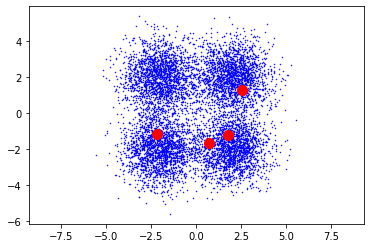

In [7]:
import random

# take a sample of k points as seeds (comment out the DEBUG line)
## TODO
centroids = random.sample(pointsar,4)
centroids = np.vstack(centroids)
print(centroids)

# (DEBUG) or use these as an example when debugging
# centroids = np.array([[2.0,2.0],[2.0,-2.0],[-2.0,2.0],[-2.0,-2.0]])

# keep a copy for rerunning
originalCentroids = centroids

showpoints(points, centroids)

In [8]:
# assign each point to a class using the assign_class function
# produces an RDD with type (int) with length equal to number of points
### TODO
clusters = points.map(lambda x: assign_class(x,centroids))


In [9]:
# build an RDD of type (int, [float, float]) that specifies the cluster and then the point coordinates
# this can be done efficiently with with `zip()` function
### TODO
ptstriples = clusters.zip(points)


Some hints for the next cell

   1. use `groupByKey()` to collect data by cluster 
   2. at the end you are going to have to use
         the function `np.mean(array, axis=0`) on a iterator. Keep the data in spark RDDs until the last step.
   3. it can be hard to materialize RDDs into arrays you need to either `np.array(RDD)` or `np.array(list(RDDiterable))`
   4. I wrote a helper function, rather than using a lambda to help take the mean because it was more readable.
   5. be careful with the ordering of your centroids. RDDs are not necessarily sorted by key.
   

In [10]:
# update the centroids to be the mean of each cluster of points 
### TODO
def iter_mean(iter):
    total=np.array([0.0,0.0])
    for idx, element in enumerate(iter):
        total+=element
    return total/(idx+1)
    
def calculate_centroids(centroids):       
    new_centroids = ptstriples.groupByKey().mapValues(iter_mean).collect()
    new_centroids = sorted(new_centroids,key=lambda x:x[0])
    new_centroids = np.vstack(list(map(lambda x:x[1], new_centroids)))
    return new_centroids

centroids = calculate_centroids(centroids)    
print(centroids)


[[-2.24571333 -0.09691285]
 [ 0.54867526 -2.32535346]
 [ 2.41164823 -1.78108503]
 [ 1.73609602  2.12567682]]


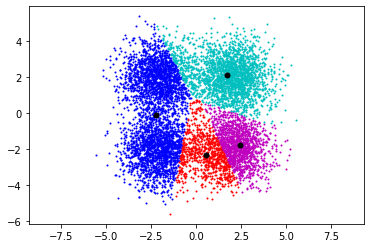

In [11]:
# look at the output of your intial clustering
plot_clusters(ptstriples, centroids)

k-means is an iterative algorithm.  You will see that the centroids progessively converge to the true means.

# Implementation 1 complete

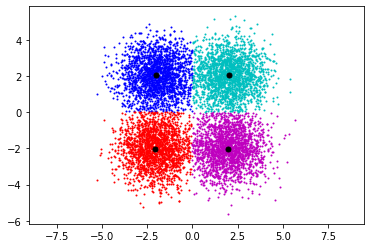

In [46]:
# %%timeit -n 1

iterations = 10 
centroids = originalCentroids

# plot_clusters(ptstriples, centroids)
for i in range(iterations):
  
    ### TODO
    # run the whole process over and over
    clusters = points.map(lambda x: assign_class(x,centroids))
    ptstriples = clusters.zip(points)
    centroids = calculate_centroids(centroids)    
    
    # optionally plot the output (could be slow)
    # plot_clusters(ptstriples, centroids)
    
plot_clusters(ptstriples, centroids)

# Debugging/Experimentation cell

In [29]:
def part_sums(clusterrdd):
    ar = np.array(list(clusterrdd))
    return (np.sum(ar, axis=0), ar.shape[0])

# helper function to aggregate the sums and counts into means 
def sums_2_means(sumslist):
    sums = sumslist[::2]
    counts = sumslist[1::2]
    return np.sum(sums, axis=0)/np.sum(counts)

# def sum_2_means_juan(list_sumlist):
#     t = 
#     for l in list_sumlist():
        
#         m = sums_2_means(l)

print(ptstriples.getNumPartitions()) 
##Collected triples 
triples = ptstriples.collect()
for ii in range(4):
    tr = list(filter(lambda x:x[0]==ii, triples))
    print(f" Points in cluster {ii}: {len(tr)}")
    print(len(points.collect()))

print("way 1")
temp = ptstriples.filter(lambda x:x[0]==0).map(lambda x:x[1]).collect()
t = np.array(list(temp))
print(t)
print(t.shape)
t = part_sums(temp)
print(t)
print(sums_2_means(t))

print("way 2")
temp = ptstriples.filter(lambda x:x[0]==0).map(lambda x:x[1])
temp2 = temp.mapPartitions(part_sums)
print(temp2.getNumPartitions())
print(temp2.collect())
temp3 = sums_2_means(temp2.collect())

print(temp3)
# temp2 = temp.foreachPartition(part_sums).collect()
# temp2 = temp.aggregate([0], part_sums,sums_2_means).collect()
temp2


1
 Points in cluster 0: 2016
8000
 Points in cluster 1: 1992
8000
 Points in cluster 2: 1991
8000
 Points in cluster 3: 2001
8000
way 1
[[-0.95909446  1.45964361]
 [-1.68925985  3.47758966]
 [-1.65529072  0.78791343]
 ...
 [-3.54605778  2.6446016 ]
 [-2.33435308  2.32966813]
 [-1.39421989  1.0455624 ]]
(2016, 2)
(array([-4059.73574039,  4021.56856002]), 2016)
[-2.01375781  1.99482567]
way 2
1
[array([-4059.73574039,  4021.56856002]), 2016]
[-2.01375781  1.99482567]


PythonRDD[131] at collect at <ipython-input-29-8cf732377fbc>:38

### Alternate Implementation

Our first implementation used a `groupBy` to collect data by cluster. This has the disadvantage that it shuffles data and collects data by partition. We will do another implementation that moves no data outside of partitions.  This will use the `filter` pattern that is implemented in the `plot_clusters` function.

Your program should filter all data within a partition and then aggregate data within each partition. I have given you the `part_sums` helper to aggregate within each partition and the `sums_2_means` helper function to convert the sums into means.

Leave all the `persist()` operations and also all the `%%timeit` directives commented out at this point.

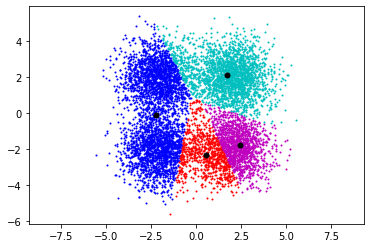

In [31]:
# helper function that returns the sum of the points in an RDD. 
# HINT: you do want to call this once per partition
def part_sums(clusterrdd):
    ar = np.array(list(clusterrdd))
    return (np.sum(ar, axis=0), ar.shape[0])

# helper function to aggregate the sums and counts into means 
def sums_2_means(sumslist):
    sums = sumslist[::2]
    counts = sumslist[1::2]
    return np.sum(sums, axis=0)/np.sum(counts)

# Create an empty array for updated centroids
ucentroids = [ None for i in range(4)]

# use the orginal centroids as input
centroids = originalCentroids

###TODO

# create clusters and ptstriples as previously
clusters = points.map(lambda x: assign_class(x,centroids))
ptstriples = clusters.zip(points)

# For each of the four clusters (repeat this code for all four clusters)

# filter for only the points in this cluster
lcluster0 = ptstriples.filter(lambda x:x[0]==0).map(lambda x:x[1]) 
# derive means in each cluster (or do it another way)
cluster0means = lcluster0.mapPartitions(part_sums)
# aggregate means from each partition and update centroids
ucentroids[0] = sums_2_means(cluster0means.collect())

lcluster1 = ptstriples.filter(lambda x:x[0]==1).map(lambda x:x[1])
cluster1means = lcluster1.mapPartitions(part_sums)
ucentroids[1] = sums_2_means(cluster1means.collect())

lcluster2 = ptstriples.filter(lambda x:x[0]==2).map(lambda x:x[1])
cluster2means = lcluster2.mapPartitions(part_sums)
ucentroids[2] = sums_2_means(cluster2means.collect())

lcluster3 = ptstriples.filter(lambda x:x[0]==3).map(lambda x:x[1])
cluster3means = lcluster3.mapPartitions(part_sums)
ucentroids[3] = sums_2_means(cluster3means.collect())

# # optionally plot the clusters (may be slow)
plot_clusters(ptstriples, np.array(ucentroids))

# Implementation 2 complete

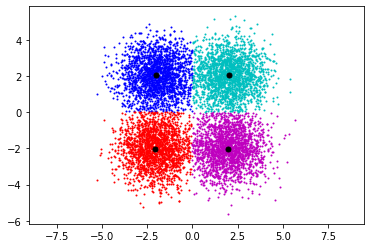

In [44]:
# %%timeit -n 1

ucentroids = [ None for i in range(4)]
centroids = originalCentroids

iterations = 10

for i in range(iterations):
    
    ### TODO
    # create clusters and ptstriples as previously
    clusters = points.map(lambda x: assign_class(x,centroids))
    ptstriples = clusters.zip(points)

    # optionally persist the triples for cache reuse
    ptstriples.persist()
    
    # run the whole process repeatedly
    lcluster0 = ptstriples.filter(lambda x:x[0]==0).map(lambda x:x[1]) 
    cluster0means = lcluster0.mapPartitions(part_sums)
    ucentroids[0] = sums_2_means(cluster0means.collect())
    
    lcluster1 = ptstriples.filter(lambda x:x[0]==1).map(lambda x:x[1])
    cluster1means = lcluster1.mapPartitions(part_sums)
    ucentroids[1] = sums_2_means(cluster1means.collect())
    
    lcluster2 = ptstriples.filter(lambda x:x[0]==2).map(lambda x:x[1])
    cluster2means = lcluster2.mapPartitions(part_sums)
    ucentroids[2] = sums_2_means(cluster2means.collect())
    
    lcluster3 = ptstriples.filter(lambda x:x[0]==3).map(lambda x:x[1])
    cluster3means = lcluster3.mapPartitions(part_sums)
    ucentroids[3] = sums_2_means(cluster3means.collect())
    
    # apply updated centroids for next iteration
    centroids = np.array(ucentroids)
 
    # optionally plot the clusters (may be slow)
plot_clusters(ptstriples, np.array(ucentroids))

### Stop the context

If you crash, you will often need to close Spark explicitly to reset the system.  Just run this cell.

In [ ]:
sc.stop()

## Questions

We now turn to an evaluation of the relative performance of our two implementations and a study of the benefit of caching.  Performance results are consistent across my 8-core laptop (MacOSX), 12-core laptop (Windows), and an 8-core droplet on Digital Ocean. Your results may vary, but you should be able to explain.

#### Question 1

Comment out all `plot_clusters` call and uncomment the `%%timeit` decorators. Run the notebook and get the timing information.

* How long did each implementation take to run?
    * Groupby implementation: <br>
   5.23 s ± 87.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) 
    * Filter implementation: <br>
   15.6 s ± 1.22 s per loop (mean ± std. dev. of 7 runs, 1 loop each) 

* The `groupBy` implementation is faster than the `filter` implementation. Why?
    * In Colab, the data is all sitting in a single node (computer). Since, there is no additional overhead for copying a transfering the data to different nodes, the shuffling operation done by `groupby` implementation works faster.

On a distributed-memory cluster, the `filter` implementation will always be faster.

* Why would the `filter` implementation run faster on distributed memory?
    * The filter implementation will performn all the computations within the partitions and combined through aggregated metrics of the data. This implies that there is no overhead due to transfering data among different nodes.

#### Question 2

There are two commented out `persist()` calls in this notebook: one for `points` and one for `ptstriples` in the `filter` implementation.  Run four versions of this code and give performance results (timings from `%%timeit`) for each of the following:
 
* persist neither `points` nor `ptstriples`
    * 15.6 s ± 1.22 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
* persist `points` but not `ptstriples`
    * 13.5 s ± 820 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* persist `ptstriples` but not `points`
    * 4.99 s ± 471 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* persist both `points` and `ptstriples`
    * 5.41 s ± 888 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    
#### Question 3

* Caching `ptstriples` in the `filter` implementation makes it faster. Explain why.
  * The `ptstriples` RDD will only materialized (get computed) in the `filter` implementation when calculating the values for the first centroid. If the `ptstriples` RRD is not made persistant, the computations to get its values have to be repeated for every centroid.
  
* Why is it more effective to cache `ptstriples` than `points`?
  * The `points` RDD only loads the data to the engine while `ptstriples` performs computation on all the points to assign them a cluster. In this regard, making `ptstriples` persistent will reduce the number of total computations.
